In [26]:
%matplotlib inline
import brian2 as b2
import matplotlib.pyplot as plt
import numpy as np
from neurodynex3.adex_model import AdEx
from neurodynex3.tools import input_factory, plot_tools

In [28]:
#parameters
MEMBRANE_TIME_SCALE_tau_s= 16 * b2.ms
MEMBRANE_CAPACITANCE_C = 370 * b2.pF #Vérifier pour pF
V_REST = -70.0 * b2.mV
ADAPTATION_TIME_CONSTANT_tau_w = 100.0 * b2.ms
V_RESET = -70.0 * b2.mV
SPIKE_TRIGGERED_ADAPTATION_INCREMENT_b = -200 * b2.pA
ABSOLUTE_REFRACTORY_PERIOD = 3.0 * b2.ms

# a technical threshold to tell the algorithm when to reset vm to v_reset
FIRING_THRESHOLD_v_spike = -50*b2.mV

In [34]:
# This function implement Adaptive Exponential Leaky Integrate-And-Fire neuron model

def simulate_soma(
        tau_s=MEMBRANE_TIME_SCALE_tau_s,
        C=MEMBRANE_CAPACITANCE_C,
        v_rest=V_REST,
        tau_w=ADAPTATION_TIME_CONSTANT_tau_w,
        I_stim=input_factory.get_zero_current(),
        v_reset=V_RESET,
        b=SPIKE_TRIGGERED_ADAPTATION_INCREMENT_b,
        v_spike=FIRING_THRESHOLD_v_spike,
        abs_refractory_period=ABSOLUTE_REFRACTORY_PERIOD,

        #v_rheobase=RHEOBASE_THRESHOLD_v_rh,
        #a=ADAPTATION_VOLTAGE_COUPLING_a,
        #delta_T=SHARPNESS_delta_T,

        simulation_time=200 * b2.ms):

    v_spike_str = "v>{:f}*mvolt".format(v_spike / b2.mvolt)

    # EXP-IF
    eqs = """
        dv/dt = -(v-v_rest)/tau_s + (I_stim(t,i) + w)/C : volt (unless refractory)
        dw/dt=-w/tau_w : amp
        """

    neuron = b2.NeuronGroup(1, model=eqs, threshold=v_spike_str, reset="v=v_reset;w+=b",refractory=abs_refractory_period, method="euler")

    # initial values of v and w is set here:
    neuron.v = v_rest
    neuron.w = 0.0 * b2.pA

    # Monitoring membrane voltage (v) and w
    state_monitor = b2.StateMonitor(neuron, ["v", "w"], record=True)
    spike_monitor = b2.SpikeMonitor(neuron)
    monitors = [state_monitor, spike_monitor]

    # running simulation
    hh_net = b2.Network(neuron)
    hh_net.add(monitors)
    hh_net.run(simulation_time)
    return state_monitor, spike_monitor

def plot_voltage_activation_and_current_traces(voltage_monitor, current, title=None, firing_threshold=None, legend_location=0):
    """plots voltage and current .

    Args:
        voltage_monitor (StateMonitor): recorded voltage
        current (TimedArray): injected current
        title (string, optional): title of the figure
        firing_threshold (Quantity, optional): if set to a value, the firing threshold is plotted.
        legend_location (int): legend location. default = 0 (="best")

    Returns:
        the figure
    """

    assert isinstance(voltage_monitor, b2.StateMonitor), "voltage_monitor is not of type StateMonitor"
    assert isinstance(current, b2.TimedArray), "current is not of type TimedArray"

    time_values_ms = voltage_monitor.t / b2.ms

    plt.figure(1, figsize=(10,8))

    # current
    axis_c = plt.subplot(311)
    c = current(voltage_monitor.t, 0)
    max_current = max(current(voltage_monitor.t, 0))
    min_current = min(current(voltage_monitor.t, 0))
    margin = 1.05 * (max_current - min_current)
    # plot the input current time-aligned with the voltage monitor
    plt.plot(voltage_monitor.t / b2.ms, c, "r", lw=2)
    if margin > 0.:
        plt.ylim((min_current - margin) / b2.amp, (max_current + margin) / b2.amp)
    # plt.xlabel("t [ms]")
    plt.ylabel("Input current [A]")
    plt.grid()
    axis_v = plt.subplot(312)
    plt.plot(time_values_ms, voltage_monitor[0].v / b2.mV, lw=2)
    if firing_threshold is not None:
        plt.plot(
            (voltage_monitor.t / b2.ms)[[0, -1]],
            [firing_threshold / b2.mV, firing_threshold / b2.mV],
            "r--", lw=2
        )
    max_val = max(voltage_monitor[0].v)
    if firing_threshold is not None:
        max_val = max(max_val, firing_threshold)
    min_val = min(voltage_monitor[0].v)
    margin = 0.05 * (max_val - min_val)
    plt.ylim((min_val - margin) / b2.mV, (max_val + margin) / b2.mV)
    plt.ylabel("membrane voltage [mV]")
    plt.grid()


    axis_w = plt.subplot(313)
    plt.plot(time_values_ms, voltage_monitor[0].w / b2.mV, lw=2)
    plt.xlabel("t [ms]")
    plt.ylabel("adaptation [mA]")
    plt.grid()


    if firing_threshold is not None:
        plt.legend(["vm", "firing threshold"], fontsize=12, loc=legend_location)

    if title is not None:
        plt.suptitle(title)
    plt.show()
    return axis_c, axis_v, axis_w

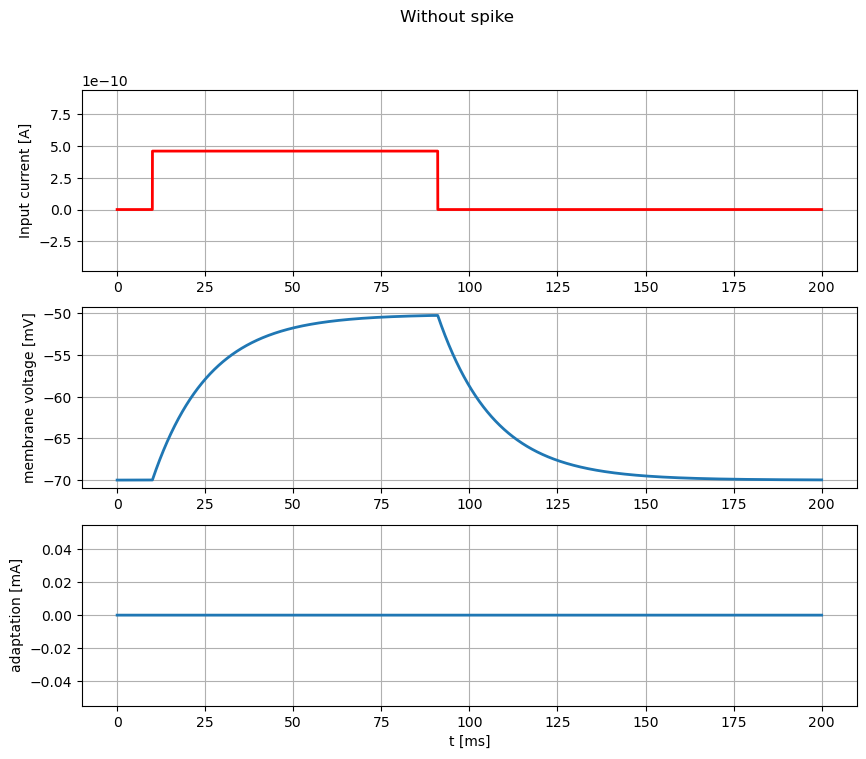

nr of spikes: 0


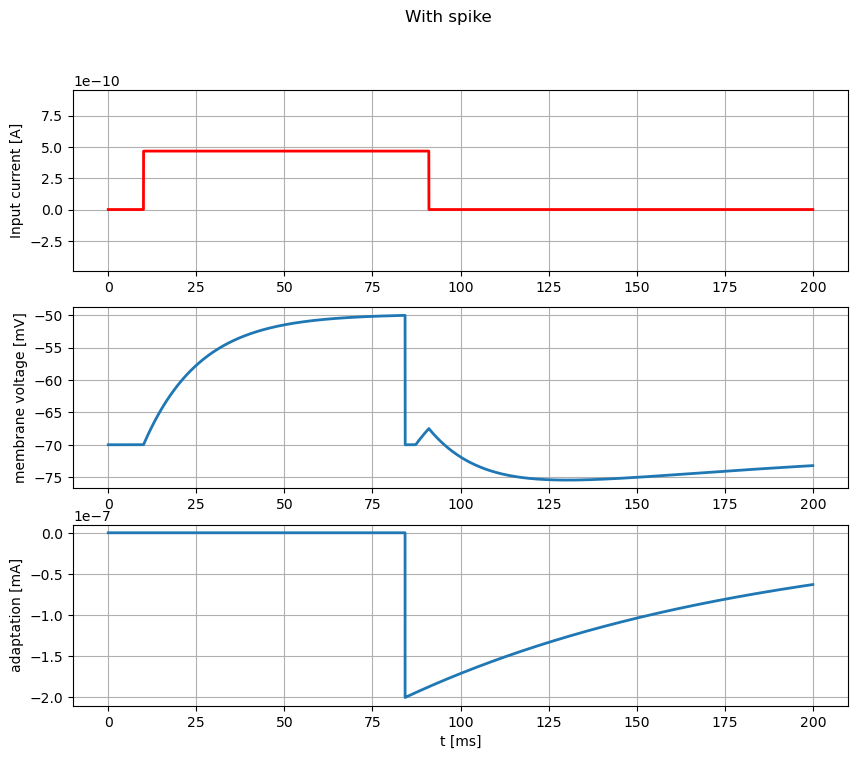

nr of spikes: 1


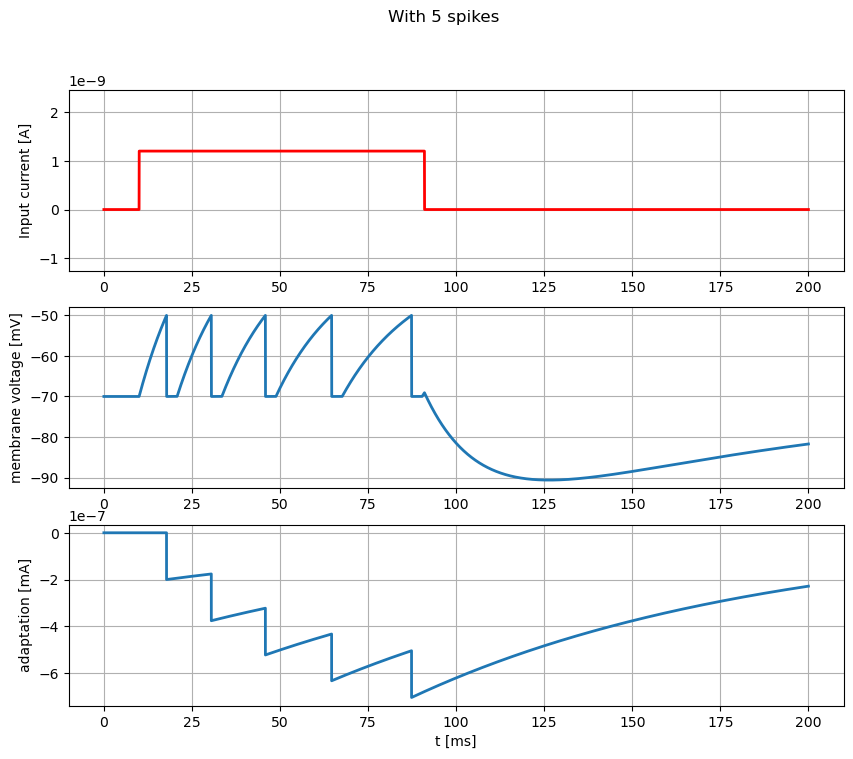

nr of spikes: 5


In [41]:
#Without spike
current = input_factory.get_step_current(10, 90, 1. * b2.ms, 0.460 * b2.nA)
state_monitor, spike_monitor = simulate_soma(I_stim=current)
plot_voltage_activation_and_current_traces(state_monitor, current, title='Without spike')
print("nr of spikes: {}".format(spike_monitor.count[0]))

#With spike
current = input_factory.get_step_current(10, 90, 1. * b2.ms, 0.467 * b2.nA)
state_monitor, spike_monitor = simulate_soma(I_stim=current)
plot_voltage_activation_and_current_traces(state_monitor, current, title='With spike')
print("nr of spikes: {}".format(spike_monitor.count[0]))

#With 5 spikes
current = input_factory.get_step_current(10, 90, 1. * b2.ms, 1.2 * b2.nA)
state_monitor, spike_monitor = simulate_soma(I_stim=current)
plot_voltage_activation_and_current_traces(state_monitor, current, title='With 5 spikes')
print("nr of spikes: {}".format(spike_monitor.count[0]))

Role de w : ralentir l'arrivée du prochain spike ? Plus le nombre de spikes augmente plus la fréquence diminue ?